# Kermack–McKendrick SIR model

The spread of an infection in a population can be modelled by a simple Kermack–McKendrick SIR Model. The population is split into three compartments: susceptible (S), infected (I), and recovered (R). The ODE of a simple SIR model looks like:

$\frac{dS}{dt} = - \frac{\beta S I}{A N}$

$\frac{dI}{dt} = \frac{\beta S I}{A N} - \gamma I $

$\frac{dR}{dt} = \gamma I $

The $\beta$ is the interaction rate between infected (*I*) and susceptible (*S*) individuals for a given area (*A*), following the law of mass action. The area is added to make easier comparisons with explicity spatial IEBMs. The total population of the system (*S*+*I*+*R*) is *N*. The $\gamma$ is the recovery rate of those infected. 

The dynamics of the model depend on a ratio called the basic reproduction number,

$ R_0 = \frac{\beta}{A \gamma} $

and the size of the susceptible compartment.

To start, this simple SIR is integrated in Python to visualize the dynamics of a parameter set. The second part of this notebook recreates the simple SIR as an IEBM. The only difference is that the SIR population 

In [1]:
# import necessary modules
import numpy as np
import matplotlib.pyplot as plt
from scipy import integrate
from multiprocessing import Pool
from tqdm.auto import tqdm

# import datatime to set threads to 1
# allows for better multiprocessing
import datatable as dt
dt.options.nthreads = 1

# set nice plotting style
plt.style.use('bmh')

## Parameters
Set parameters that are used in both the ODE and IEBM

In [2]:
b = 1000 # interaction rate
d = 0.001 # recovery rate
# size of environmnet
xdim = 500
ydim = 500
A = xdim * ydim
# simulation times
max_time = 10000
ode_times=  np.linspace(0, max_time, 100)
# population size
pop_size = 1000
init_size = [900,100,0]
# for the IEBM
pred_radius = 1
init_frac = [0.9, 0.1, 0]

## ODE

In [3]:
def dN_dt(N, t=0):
    return np.array([-(b*N[0]*N[1])/(pop_size*A),
                     (b*N[0]*N[1])/(pop_size*A) - d*N[1],
                     d*N[1]])


In [4]:
X = integrate.odeint(dN_dt, init_size, ode_times)

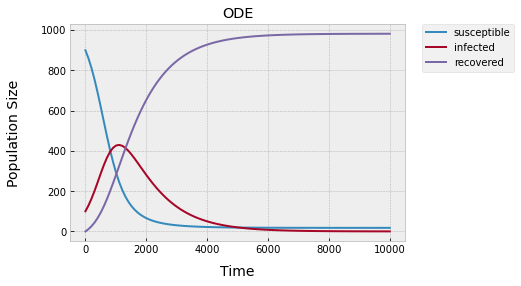

In [5]:
fig, ax = plt.subplots()
ax.plot(ode_times, X[:,0], label='susceptible')
ax.plot(ode_times, X[:,1], label='infected')
ax.plot(ode_times, X[:,2], label='recovered')
#ax.set_ylim(0, pop_size)
ax.set_title('ODE')
ax.set_ylabel('Population Size', labelpad=20, fontsize=14)
ax.set_xlabel('Time', labelpad=10, fontsize=14)
plt.legend(bbox_to_anchor=(1.05,1), loc='upper left', borderaxespad=0)
plt.show()

## IEBM

The SIR model can be recreated as an IEBM following these steps

In [6]:
# point path to IEBM files
import sys
sys.path.append('../../')
# model population in 2-dimensions
from iebm.populations.population2D import Population2D
# import Trait classes to set up Events
from iebm.traits.static_trait import StaticTrait
from iebm.traits.linked_trait import LinkedTrait
from iebm.traits.categorical_trait import CategoricalTrait
# movement is simulated by time to boundary (wall) events
from iebm.events.wall import WallEvent
# import 2D interaction for 2D populations
from iebm.events.interact2d import Interact2DEvent
# import event to handle infections
from iebm.events.infection import InfectionSIREvent
# import class to simulate model
from iebm.simulation import Simulation

# we need to update the model
import datatable as dt
import heapq

In [7]:
# start with a blank population
pop = Population2D(name='pop', init_size=pop_size, xdim=xdim, ydim=ydim)

# the interaction rate (b) can be converted into a speed based on a derivation 
# in Donalson & D'angelis (1999) from their predator-prey model
vel = b * np.pi / (8 * (pred_radius + pred_radius)) / pop_size

# the population needs 5 traits
# 1. A radius for individual body sizes. The radius is StaticTrait that doesn't 
#    ever change between individuals
# 2. An interact_radius that is the distance between individuals for them to 
#    interact. The interact_radius is a LinkedTrait that depends on the radius. 
#    In this case, the interact_radius is the same as the radius, so interactions 
#    occur at a collision.
# 3. A velocity trait is static and uses the derived vel value above
# 4. A categorical infection trait. Each individual can be one of the categories
#    depending on the given fractions. Exactly how individuals change states 
#    is determind by the infection event. This trait will also be tracked to 
#    see how it changes in the population over time
# 5. A recovery_rate trait is the population level value of d   
traits = [(StaticTrait, {'name' : 'radius', 
                         'value' : pred_radius}), 
          (LinkedTrait, {'name' : 'interact_radius', 
                         'link_trait' : 'radius', 
                         'link_func' : lambda x: x}),
          (StaticTrait, {'name' : 'velocity', 
                         'value' : vel}),
          (CategoricalTrait, {'name' : 'infection', 
                              'categories' : ['susceptible', 
                                              'infected', 
                                              'recovered'],
                              'fractions' : init_frac, 
                              'track' : True}), 
          (StaticTrait, {'name' : 'recovery_rate', 
                         'value' : d})]

# from these 5 traits, the population needs 3 Events
# 1. WallEvent to handle movement based on the velocity trait. This is a primary
#    event because the next wall event needs to be pre-calculated and stored 
# 2. InteractEvent to calculate interactions between individuals of the population 
#    and trigger secondary events. Also a primary event so value can be pre-
#    calculated.
# 3. InfectionSIREvent is a secondary event after an interaction that handles 
#    both the transmission and recovery of the infection
events = [(WallEvent, {'name' : 'wall', 
                       'is_primary' : True, 
                       'current_time' : 0, 
                       'bounce' : 'random'}),
          (Interact2DEvent, {'name' : 'interact',
                             'is_primary' : True,
                             'current_time'  : 0}), 
          (InfectionSIREvent, {'name' : 'infection', 
                               'is_primary' : False, 
                               'current_time' : 0})]

# lets add these traits and events to the population
pop.add_traits(traits)
pop.add_events(events)

In [8]:
# next we need to set the secondary triggers

# after a wall collision, the direction is changed and new interactions
# need to be pre-calculated and stored.
pop.event_dict['wall'].triggers = pop.event_dict['interact'].set_next

# after an interaction, an infection could be transmitted
pop.event_dict['interact'].triggers = pop.event_dict['infection'].handle

In [9]:
# add the pop to a dictionary 
pop_dict = {str(pop) : pop}
# create the simulation with the population dictionary
sim = Simulation(pop_dict)

In [10]:
# before we run the simulation, one more things needs to be set. This is 
# specific to the SIR model. The trait of some individuals have been set to
# "infected", but no recovery event is in the sim event_heap. The recovery
# event is a secondary event only added to the heap after an infection --- 
# there is no column in the population dataframe for recovery time and so
# no recovery events are in the heap for those initially infected indivuals.
# as the simulation runs, new infected will have the recovery event added.

# iterate over all infected individuals in the population
for i in pop.df[dt.f.infection=='infected', 'id'].to_numpy().reshape(-1):
    # explicity create a recovery event for an individual
    params = dict(actor_id = i, current_time = 0)
    new_event = pop.event_dict['infection'].set_next(params)
    # add single new event to the heap
    heapq.heappush(sim.event_heap, new_event[0])

In [11]:
%%time
# run simulation
sim.run(max_time)


CPU times: user 1min 15s, sys: 3.24 s, total: 1min 18s
Wall time: 1min 14s


In [12]:
# get the tracked trait history for each compartment from the simulation
infect_dict = dict(infected = [], recovered = [], susceptible = [])
for time, (labels, counts) in zip(sim.time_history, 
                                  sim.trait_history[('pop', 'infection')]):
    for t in ['susceptible', 'infected', 'recovered']:
        if t in labels:
            infect_dict[t].append(counts[np.where(labels==t)][0])
        else:
            infect_dict[t].append(0)

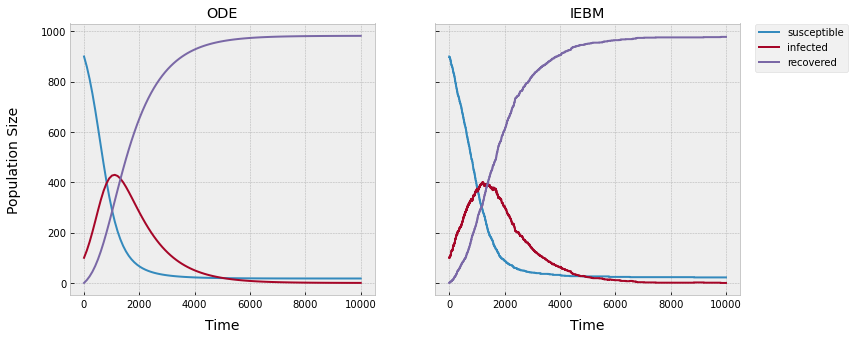

In [13]:
fig, ax = plt.subplots(1,2, figsize=(12,5), sharex=True, sharey=True)

ax[0].plot(ode_times, X[:,0], label='susceptible')
ax[0].plot(ode_times, X[:,1], label='infected')
ax[0].plot(ode_times, X[:,2], label='recovered')
ax[0].set_title('ODE')
ax[0].set_ylabel('Population Size', labelpad=20, fontsize=14)
ax[0].set_xlabel('Time', labelpad=10, fontsize=14)

for k in ['susceptible', 'infected', 'recovered']:
    ax[1].plot(sim.time_history[:-1], infect_dict[k], label=k)
ax[1].set_title('IEBM')
ax[1].set_xlabel('Time', labelpad=10, fontsize=14)

plt.legend(bbox_to_anchor=(1.05,1), loc='upper left', borderaxespad=0)

plt.show()